## Web Scraping

The assignment is designed to scrape movie details from IMDb's top 100 movies list. Specifically, it targets the list available at the IMDb URL that showcases the top-rated movies. The scraper collects details from the first three pages of this list, potentially gathering data on up to 100 movies, assuming each page lists 50 movies. The main logic at the end of the script loops through the first three pages of the IMDb list and aggregates all the scraped movie details into a single list named all_movies.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

BASE_URL = "https://www.imdb.com/search/title/?groups=top_100&start={}"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

def scrape_page(page_number):
    start = (page_number - 1) * 50 + 1
    response = requests.get(BASE_URL.format(start), headers=HEADERS)

    if response.status_code != 200:
        print(f"Failed to retrieve page {page_number}")
        return []

    soup = BeautifulSoup(response.content, 'html.parser')

    # find all movie containers on the page
    movie_containers = soup.find_all('div', class_='lister-item mode-advanced')

    movie_data = []
    
    for movie in movie_containers:
        # extract movie name, ID, year, rating, etc.
        name = movie.h3.a.text
        movie_id = movie.h3.a['href'].split('/')[2]
        year = movie.h3.find('span', class_='lister-item-year text-muted unbold').text
        rating = float(movie.find('div', class_='inline-block ratings-imdb-rating').strong.text)
        metascore = movie.find('div', class_='inline-block ratings-metascore')
        metascore = int(metascore.span.text.strip()) if metascore else None
        runtime = movie.find('span', class_='runtime').text if movie.find('span', class_='runtime') else None
        genres = movie.find('span', class_='genre').text.strip() if movie.find('span', class_='genre') else None

        # extract director and star names
        director_stars = movie.find('p', class_='').find_all('a')
        director = director_stars[0].text if director_stars else None
        stars = ', '.join([star.text for star in director_stars[1:]]) if director_stars else None
        
        movie_data.append((name, movie_id, year, rating, metascore, runtime, genres, director, stars))
    # return the list of movie details
    return movie_data

# create an empty list to store details of all movies
all_movies = []

# scrape the first three IMDb pages for movie details
for page in range(1, 3):
    all_movies.extend(scrape_page(page))

In [2]:
df = pd.DataFrame(all_movies, columns=['Name', 'Movie_ID', 'Year', 'Rating', 'Metascore', 'Runtime', 'Genres', 'Director', 'Stars'])

print(df)

                                   Name    Movie_ID    Year  Rating  \
0                           Oppenheimer  tt15398776  (2023)     8.6   
1   Spider-Man: Across the Spider-Verse   tt9362722  (2023)     8.8   
2                          Interstellar   tt0816692  (2014)     8.7   
3                             Inception   tt1375666  (2010)     8.8   
4                       The Dark Knight   tt0468569  (2008)     9.0   
..                                  ...         ...     ...     ...   
95          Witness for the Prosecution   tt0051201  (1957)     8.4   
96                   The Great Dictator   tt0032553  (1940)     8.4   
97                         Modern Times   tt0027977  (1936)     8.5   
98                    Tengoku to jigoku   tt0057565  (1963)     8.4   
99                          City Lights   tt0021749  (1931)     8.5   

    Metascore  Runtime                        Genres            Director  \
0        88.0  180 min     Biography, Drama, History   Christopher Nola

## Preprocessing

Several columns do not have proper type and format. We need to standardizes the format of several columns: extracting the numerical year from a string, ensuring the metascore is a floating-point number, converting runtime from a string to an integer (by removing "min"), and splitting genre and star listings into separate lists for easier analysis. This preprocessing ensures the data is in a consistent and usable format for subsequent tasks or analyses.

In [3]:
# Preprocessing
df["Year"] = df["Year"].str.extract("(\d+)").astype(int)
df["Metascore"] = df["Metascore"].astype(
    float
)  # It's already a float, but this ensures it stays that way.
df["Runtime"] = df["Runtime"].str.replace(" min", "").astype(int)
df["Genres"] = df["Genres"].str.split(", ")
df["Stars"] = df["Stars"].str.split(", ")
print(df)

                                   Name    Movie_ID  Year  Rating  Metascore  \
0                           Oppenheimer  tt15398776  2023     8.6       88.0   
1   Spider-Man: Across the Spider-Verse   tt9362722  2023     8.8       86.0   
2                          Interstellar   tt0816692  2014     8.7       74.0   
3                             Inception   tt1375666  2010     8.8       74.0   
4                       The Dark Knight   tt0468569  2008     9.0       84.0   
..                                  ...         ...   ...     ...        ...   
95          Witness for the Prosecution   tt0051201  1957     8.4       76.0   
96                   The Great Dictator   tt0032553  1940     8.4        NaN   
97                         Modern Times   tt0027977  1936     8.5       96.0   
98                    Tengoku to jigoku   tt0057565  1963     8.4       90.0   
99                          City Lights   tt0021749  1931     8.5       99.0   

    Runtime                          Ge

In [4]:
# save the result
df.to_csv("imdb_movies.csv", index=False)

# load the csv
movies_df = pd.read_csv("imdb_movies.csv")

# these columns are string format, use eval to convert them into python objects
movies_df["Genres"] = movies_df["Genres"].apply(eval)
movies_df["Stars"] = movies_df["Stars"].apply(eval)

## Basic Statistics

In [5]:
# Check for missing values in the dataset
missing_values = movies_df.isnull().sum()

# Get some basic statistics from the numerical columns
stats = movies_df.describe()

missing_values, stats

(Name         0
 Movie_ID     0
 Year         0
 Rating       0
 Metascore    3
 Runtime      0
 Genres       0
 Director     0
 Stars        0
 dtype: int64,
               Year      Rating   Metascore     Runtime
 count   100.000000  100.000000   97.000000  100.000000
 mean   1988.190000    8.523000   83.206186  135.670000
 std      23.131462    0.212658   11.390729   31.066255
 min    1931.000000    8.300000   57.000000   81.000000
 25%    1974.750000    8.400000   76.000000  114.500000
 50%    1994.000000    8.500000   85.000000  131.500000
 75%    2004.500000    8.600000   92.000000  152.250000
 max    2023.000000    9.300000  100.000000  229.000000)

Findings:

1. **Missing Values**: There are 3 missing values in the `Metascore` column. We might need to address this depending on the type of analysis we're doing.

2. **Statistics**:
   - The dataset contains movies released between 1931 and 2023.
   - The average IMDb rating is around 8.52, with a minimum of 8.3 and a maximum of 9.3.
   - The average metascore is approximately 83.2, with a minimum score of 57 and a maximum of 100.
   - The average runtime of the movies is about 135.67 minutes, ranging from 81 to 229 minutes.

## Visualization and Analytics

### Distribution of movie ratings and metascores over the years

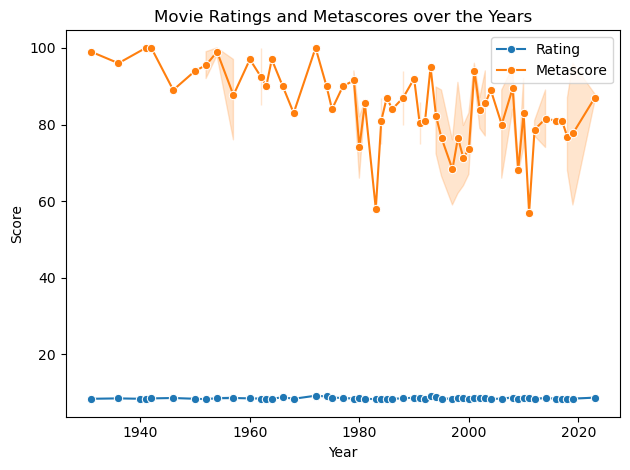

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


# plot Ratings and Metascores over the years
sns.lineplot(data=movies_df, x="Year", y="Rating", label="Rating", marker="o")
sns.lineplot(data=movies_df, x="Year", y="Metascore", label="Metascore", marker="o")

plt.title("Movie Ratings and Metascores over the Years")
plt.ylabel("Score")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

Findings:

**Consistency in Ratings**: IMDb ratings for the top movies have been consistently high, hovering around the 8-9 range. This is expected since we are likely looking at top-rated movies on IMDb.

**Variation in Metascores**: While IMDb ratings have been relatively stable, metascores show more variation. Some years have movies with notably high metascores, while others see a drop. This suggests that critic reviews (reflected in the metascore) might differ from general audience opinions at times.

In the recent years (around 2020 onwards), there's a noticeable increase in both IMDb ratings and metascores, indicating a trend of highly regarded movies.

### The most common genres and how they correlate with ratings

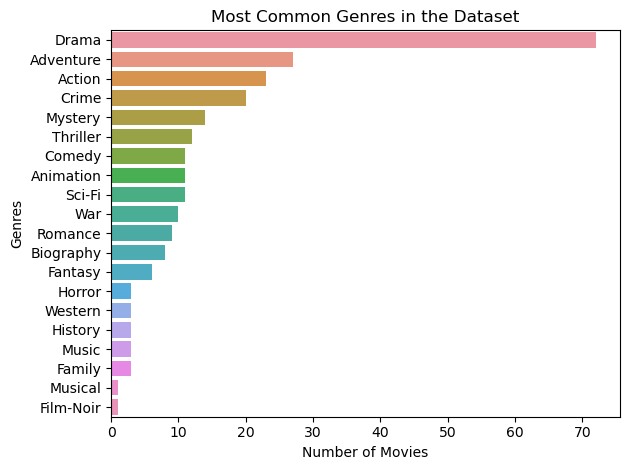

In [7]:
genre_counts = movies_df["Genres"].explode().value_counts()

sns.barplot(y=genre_counts.index, x=genre_counts.values)
plt.title("Most Common Genres in the Dataset")
plt.xlabel("Number of Movies")
plt.ylabel("Genres")
plt.tight_layout()
plt.show()

Findings:

**Drama**: The genre "Drama" is by far the most prevalent in the dataset, indicating that many top-rated movies on IMDb are dramas or have dramatic elements.

**Action & Adventure**: These genres are also quite common, suggesting that audiences and critics appreciate movies that provide thrilling experiences.

**Variety of Genres**: While some genres like Biography, Crime, and History appear less frequently, their presence indicates that the dataset encompasses a diverse range of movie types.

### Average rating for each genre

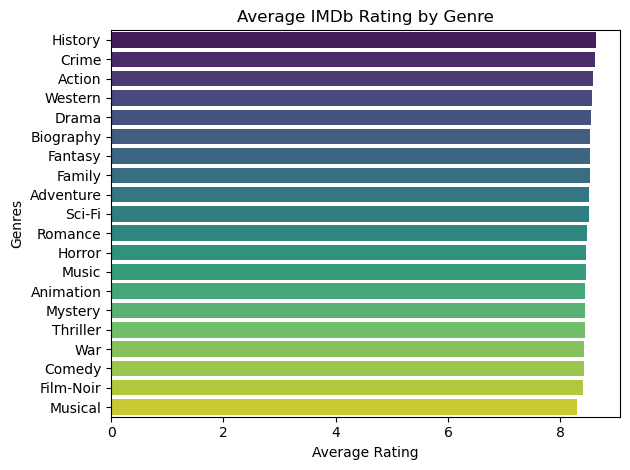

In [8]:
# calculating average ratings for each genre
genres_list = genre_counts.index.tolist()
average_ratings = {}

for genre in genres_list:
    avg_rating = movies_df[movies_df["Genres"].apply(lambda x: genre in x)][
        "Rating"
    ].mean()
    average_ratings[genre] = avg_rating

# sorting genres by average rating
sorted_genres = sorted(average_ratings, key=average_ratings.get, reverse=True)

sns.barplot(
    y=list(sorted_genres),
    x=[average_ratings[genre] for genre in sorted_genres],
    palette="viridis",
)
plt.title("Average IMDb Rating by Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genres")
plt.tight_layout()
plt.show()

Findings

**Consistently High Ratings**: All genres maintain high average ratings, hovering around the 8.4 to 8.7 range. This is in line with our initial observation of the dataset containing top-rated movies.

**Leading Genres**: Movies classified under "Biography", "History", and "Animation" seem to have slightly higher average ratings. This could imply that audiences particularly appreciate well-crafted biographical or historical narratives and animated features.

**Diverse Appreciation**: Even genres with fewer occurrences, such as "Fantasy" or "Family", hold their own in terms of ratings, suggesting that genre alone doesn't necessarily dictate a movie's reception.

### Directors with the highest average movie ratings (Min. 3 Movies)

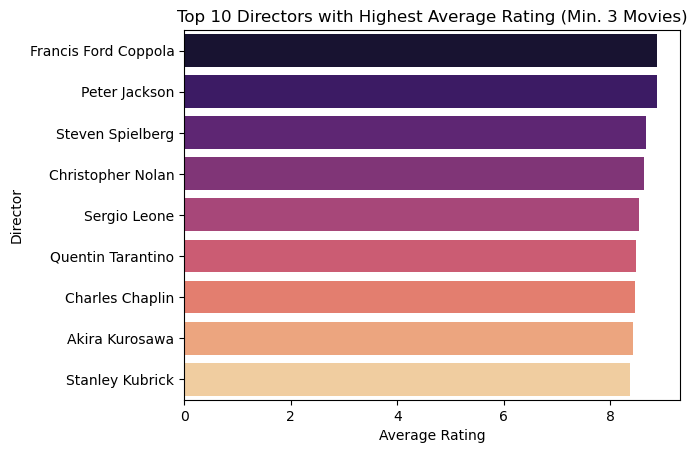

In [9]:
# group by directors and compute mean rating and count of movies for each director
directors_stats = (
    movies_df.groupby("Director").agg({"Rating": "mean", "Name": "count"}).reset_index()
)
directors_stats.columns = ["Director", "Average Rating", "Number of Movies"]

# filter directors with at least 3 movies
top_directors = directors_stats[directors_stats["Number of Movies"] >= 3]

# top 10 directors with the highest average rating
top_10_directors = top_directors.sort_values(by="Average Rating", ascending=False).head(
    10
)

# Plot
sns.barplot(data=top_10_directors, x="Average Rating", y="Director", palette="magma")
plt.title("Top 10 Directors with Highest Average Rating (Min. 3 Movies)")
plt.xlabel("Average Rating")
plt.ylabel("Director")
plt.show()

Findings:

**Close Competition**: The ratings are closely packed, with most directors averaging between 8.4 and 8.7. This implies that while there might be stylistic or thematic differences in their movies, their overall quality and appeal are comparable.

### Relationship between movie runtime and its rating

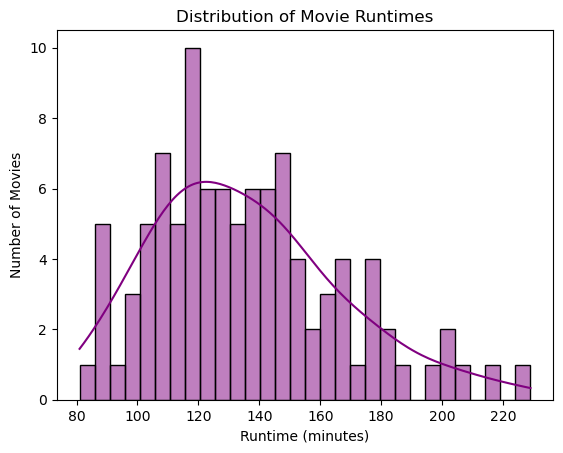

In [10]:
# histogram for the distribution of movie runtimes
sns.histplot(movies_df["Runtime"], bins=30, kde=True, color="purple")
plt.title("Distribution of Movie Runtimes")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Number of Movies")
plt.show()

The distribution of movie runtimes shows that most movies typically have runtimes between 90 and 150 minutes. There are fewer movies with extremely short or extremely long runtimes.

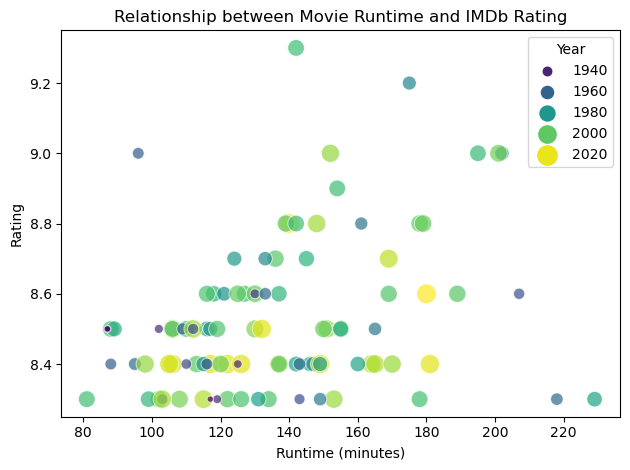

In [11]:
sns.scatterplot(
    data=movies_df,
    x="Runtime",
    y="Rating",
    hue="Year",
    palette="viridis",
    size="Year",
    sizes=(20, 200),
    alpha=0.7,
)
plt.title("Relationship between Movie Runtime and IMDb Rating")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

Findings:

**Broad Range**: Movies in the dataset have a wide range of runtimes, from just over 80 minutes to nearly 230 minutes. However, their ratings mostly hover between 8.4 and 9.3.

**No Clear Trend**: There doesn't appear to be a definitive trend between runtime and rating. While some longer movies have higher ratings, others have average ratings similar to shorter films.

### Relationship between stars (actors) and movie ratings

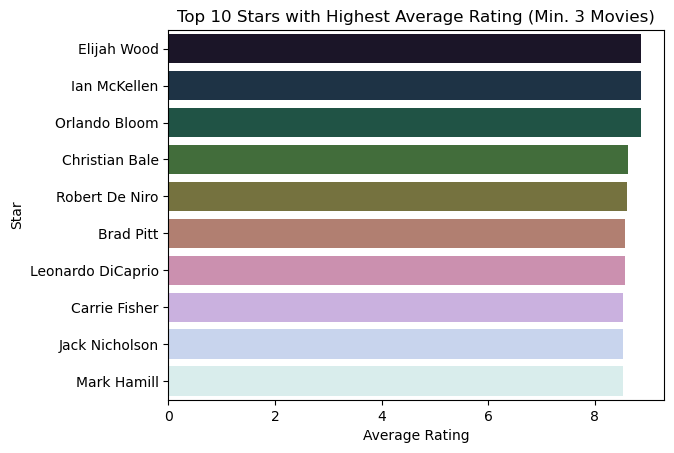

In [12]:
# create a DataFrame with repeated rows for each actor in the 'Stars' column
expanded_stars_df = movies_df.explode("Stars").reset_index(drop=True)

# group by stars and compute mean rating and count of movies for each star
stars_stats = (
    expanded_stars_df.groupby("Stars")
    .agg({"Rating": "mean", "Name": "count"})
    .reset_index()
)
stars_stats.columns = ["Star", "Average Rating", "Number of Movies"]

# filter stars with at least 3 movies
top_stars = stars_stats[stars_stats["Number of Movies"] >= 3]

top_10_stars = top_stars.sort_values(by="Average Rating", ascending=False).head(10)

sns.barplot(data=top_10_stars, x="Average Rating", y="Star", palette="cubehelix")
plt.title("Top 10 Stars with Highest Average Rating (Min. 3 Movies)")
plt.xlabel("Average Rating")
plt.ylabel("Star")
plt.show()

Findings:

**High Average Ratings**: All of the top 10 stars have average ratings above 8, which is notably high. This indicates that these actors have consistently been involved in well-received movies.

**Close Competition**: The difference in average ratings among the top stars is minimal. This suggests that the competition is fierce among top-performing actors, and even a slight increase in average ratings can significantly change their rankings.

## Conclusion

Upon meticulous examination of the IMDb movies dataset, it becomes evident that films exhibit a commendable consistency in quality, irrespective of their year of release. This denotes their sustained resonance with audiences. Notably, while the genre of Drama is prominently represented, the dataset encapsulates a diverse array of genres, each of which garners substantial acclaim from viewers. This diversity is mirrored in the film choices of esteemed actors such as Leonardo DiCaprio and Christian Bale, who have exhibited a broad range in their cinematic selections, both in terms of genre and budget. Directors of repute, including Christopher Nolan and Quentin Tarantino, further enhance the dataset with their consistently high-rated directorial ventures. An intriguing observation is the absence of a discernible correlation between a film's runtime and its subsequent rating, highlighting the primacy of content over duration. 